# Summarizing Google News Headlines

Daniel Souza de Campos - 01/2025


# 1. Context and Problem

Google News is one of the main websites to get news from multiple sources for a given searched term. The thing is that, when you search a term, you get a lot of news to go through and many of them talk about the same thing (are somewhat duplicated) as many sources may talk about the same fact about the searched term. This is not a good experience if you just want a quick understanding of the news about the searched term.

This work aims to summarize the headlines for a set of news to give a better experience for those whose just want a fast grip of what is going on about what they've searched for.

I summarize only the headlines and not the actual news text so I don't have to enter every news site. I'm also basing myself on the understanding that the headlines are theirselves summaries of their respective texts.

# 2. Data used

The experiments in this notebook were done on a set of headlines and sources for 15 different target terms of the autor's interest. They were collected on 23/01/2025. These terms can be divided in groups and are (in portuguese):

-- Football --
- Cruzeiro Esporte Clube
- Clube Atlético Mineiro
- Campeonato Mineiro de Futebol
- Neymar

-- Location --
- Ucrânia
- Venezuela
- China
- Rússia
- Síria
- Itabirito
- Belo Horizonte

-- Politics and Economics --
- Donald Trump
- Dólar
- Lula

-- Entertainment --
- GTA 6

## Downloading code from the Git repo

In [1]:
import requests
import zipfile
import pathlib

target_zip_path = pathlib.Path("download/main.zip")
target_zip_path.parent.mkdir(exist_ok=True, parents=True)

if target_zip_path.exists():
  target_zip_path.unlink()

print("Downloading github repo")
github_url = "https://github.com/Pendulun/google-news-summarization/archive/refs/heads/main.zip"
response = requests.get(github_url)

with open(target_zip_path, "wb") as f:
    f.write(response.content)

target_unziped_folder = pathlib.Path("download/")

print("Unziping")
with zipfile.ZipFile(target_zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_unziped_folder)

target_zip_path.unlink()
code_folder = target_unziped_folder / "google-news-summarization-main"

Unziping


## Changing directory

In [2]:
%cd download/google-news-summarization-main

/content/download/google-news-summarization-main


## 2.1 Number of headlines for terms

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

searches_dir_path = pathlib.Path("data/searches")

searches_count = dict()
for search_file in searches_dir_path.glob("*.csv"):
  searches_count[search_file.stem] = [len(pd.read_csv(search_file, delimiter=';'))]

searches_count_df = pd.DataFrame(searches_count)
searches_count_df.index = ['count']

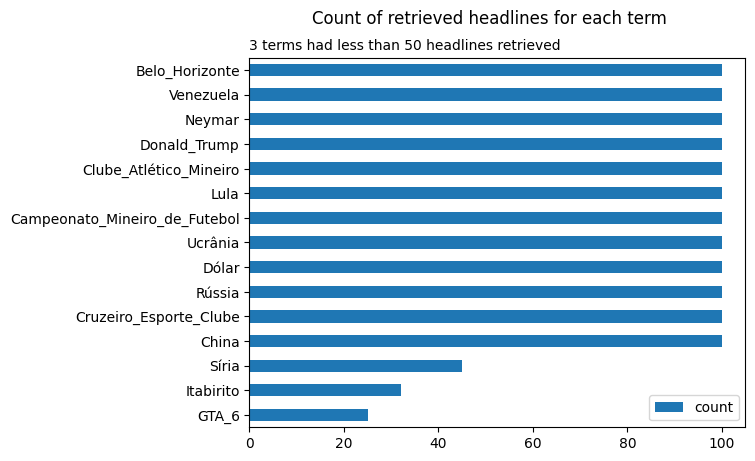

In [5]:
searches_count_df.T.sort_values(by='count').plot(kind='barh')
plt.suptitle("Count of retrieved headlines for each term")
plt.title("3 terms had less than 50 headlines retrieved", fontsize=10, loc='left')
plt.show()

The above image shows that every term had 100 headlines retrieved but 3. Those 3 headlines had less than 50 headlines each.

This is a important thing to take into consideration when analyzing the experiment results.

# 3. Methodology and tools

First of all, the news set are retrieved using the [GoogleNews](https://github.com/Iceloof/GoogleNews) Python library.

Then, the experiments to reach the goal were based on a pipeline with many options. The following figure shows the pipeline steps and options.

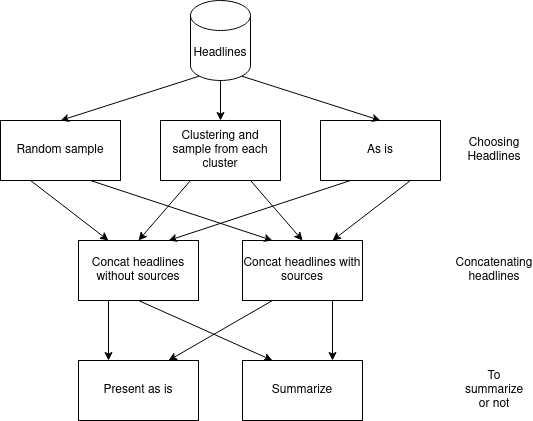

In [6]:
from IPython.display import Image
Image(filename='data/assets/summarization_pipeline.png')

We see that the pipeline has 3 steps:
1. Choose Headlines:
  - How to choose the headlines that will be part of the rest of the pipeline. We can have all, sample randomly or cluster and than sample from each headline cluster.
  - I use the `https://huggingface.co/BAAI/bge-m3` model to get a sentence embedding and then use `sklearn.cluster.DBSCAN` on the embeddings to get the clusters.
  - I chose to use `DBSCAN` because I don't know how many clusters there will be for each set of headlines.
2. Concatenate Headlines:
  - How to concat the headlines and it's sources to group them in one large text.
  - We take or don't take into consideration the news source to do this.
3. Summarize or not:
   - Finally, we can actually summarize or don't summarize at all.
   - This is a thing as the clustering and choosing some headlines may be already a suficient solution.
   - To summarize the incoming text, I use the `https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum` model, a `mT5 checkpoint finetuned on the 45 languages of XL-Sum dataset.`

## Installing dependencies

In [7]:
!uv pip install --system -r requirements.txt

Using Python 3.11.11 environment at /usr
Resolved 53 packages in 402ms
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   ------------------------------     0 B/234.13 KiB
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   ------------------------------     0 B/234.13 KiB
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   ------------------------------ 14.91 KiB/234.13 KiB
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   ------------------------------ 14.91 KiB/234.13 KiB
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   ------------------------------ 30.91 KiB/234.13 KiB
dateparser ------------------------------     0 B/288.08 KiB
⠙ Preparing packages... (0/4)
coverage   -

In [8]:
import main
import src.clustered_sampling
import importlib

importlib.reload(src.clustered_sampling)

<module 'src.clustered_sampling' from '/content/download/google-news-summarization-main/src/clustered_sampling.py'>

# 4. Experiments

## 4.1 Evaluating the eps DBSCAN parameter for each searched term

DBSCAN has an argument called `eps`. This argument controls the maximum distance that a point can be from another for both to be considered part of the same cluster.

The embeddings generated by the `BAAI/bge-m3` model have a dimension of `1024` and are normalized.

Let's evaluate, for each search term, the effect of varying the value of `eps` on the number of groups generated by DBSCAN. It should be noted that one of the groups generated by DBSCAN may be equal to `-1`, which means `outliers`. Thus, if the total number of groups produced is 1, it may be that all headlines are from the same cluster or all of them are to be considered outliers in a sense that, using the defined eps value, no group could be formed. Both cases are not good and I try to have at least 2 groups based on the fact that many headlines may be talking about the same fact about the searched term.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pathlib
from tqdm.auto import tqdm

import src.clustered_sampling
import importlib

importlib.reload(src.clustered_sampling)

SAFEGUARD = True # If you really want to run the experiment, set this to False

eps_results_file_path = pathlib.Path("data/eps_results.csv")
searches_dir = pathlib.Path("data/searches")

if not SAFEGUARD:
  print("[LOG] Running experiment 1...")
  sampler = src.clustered_sampling.ClusteredSample()
  sampler.set_model('BAAI/bge-m3')

  clusters_per_term = dict()
  for searched_file in tqdm(searches_dir.glob("*.csv")):
      term = searched_file.stem
      print("[LOG] Term:", term)
      df = pd.read_csv(searched_file, delimiter=';')
      headlines = df.to_dict(orient='records')

      dataset = src.clustered_sampling.HeadlinesDataset(headlines)
      np_embs = sampler.get_embeddings(dataset, batch_size=32)
      for eps in np.arange(0.01, 0.1, 0.005):
        cluster_labels = sampler._get_clustering_labels(
                    np_embs, {'eps':eps}
                    )
        clusters_per_term.setdefault(term, dict())[eps] = len(np.unique(cluster_labels))

  eps_results_df = pd.DataFrame(clusters_per_term)
  print("[LOG] Saving results to ", eps_results_file_path)
  eps_results_df.to_csv(eps_results_file_path)
else:
  print("[LOG] Loading eps results file from", eps_results_file_path)
  eps_results_df = pd.read_csv(eps_results_file_path, index_col='Unnamed: 0')

[LOG] Loading eps results file from data/eps_results.csv


In [10]:
eps_results_df.head()

,GTA_6,Lula,Donald_Trump,Itabirito,Belo_Horizonte,Rússia,Ucrânia,Venezuela,Neymar,Síria,Dólar,Campeonato_Mineiro_de_Futebol,Clube_Atlético_Mineiro,Cruzeiro_Esporte_Clube,China
0.010,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2
0.015,1,2,1,1,1,2,3,2,1,1,1,1,1,1,2
0.020,1,2,1,1,2,2,3,3,1,1,3,2,1,1,3
0.025,1,3,1,1,4,2,3,3,4,1,4,3,2,2,3
0.030,1,4,3,2,5,3,4,3,5,1,2,4,3,3,3


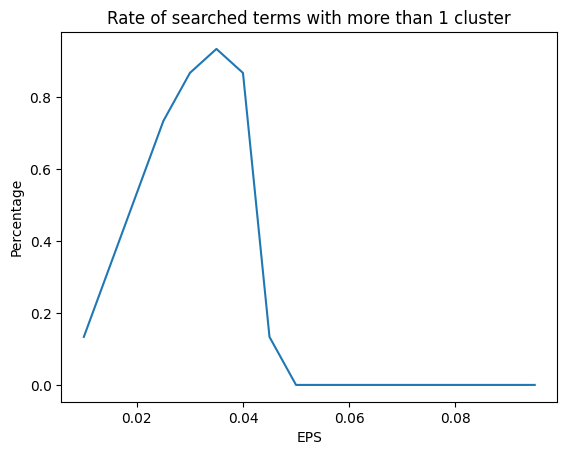

In [11]:
((eps_results_df > 1).sum(axis=1)/eps_results_df.shape[1]).plot()
plt.xlabel("EPS")
plt.ylabel("Percentage")
plt.title("Rate of searched terms with more than 1 cluster")
plt.show()

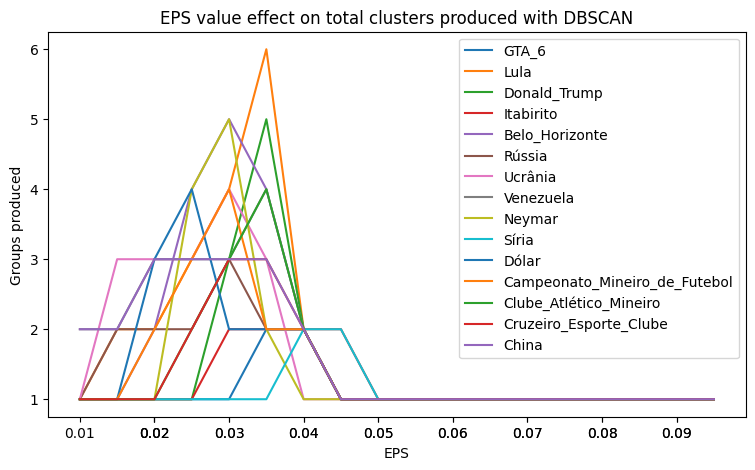

In [12]:
plt.figure(figsize=(9, 5))
eps_results_df.plot(ax=plt.gca())
xticks = np.round(eps_results_df.index.values, 2)
plt.xticks(xticks, xticks)
plt.xlabel("EPS")
plt.ylabel("Groups produced")
plt.title("EPS value effect on total clusters produced with DBSCAN")
plt.show()

According to the graphs above, we can see that with `eps=0.035` it is possible to identify more than 1 group in more than 80% of the article titles for the searched terms. Thus, this value will be used to generate the article title clusters in the following experiments.

In [13]:
EPS = 0.035

## 4.2 Evaluating the pipeline's options

I decided to evaluate only some of the (3 * 2 * 2 = 12) pipeline possible configurations. They are:
1. Random-Sample; Concat without sources; present as is
2. Random-Sample; Concat with source; Summarize
3. Clustering; Concat with source; Present as is
4. Clustering; Concat with source; Summarize
5. As is; Concat without source; Summarize

For each configuration, I ran the pipeline over the 15 terms news and collected the outputs.

In [14]:
from src.pipeline import SamplerTypes, JoinerTypes, SolverTypes

pipeline_configs = {
    "1":(SamplerTypes.RANDOM, JoinerTypes.AS_IS, SolverTypes.AS_IS),
    "2":(SamplerTypes.RANDOM, JoinerTypes.WITH_SOURCE, SolverTypes.LLM_SUMMARIZATION),
    "3":(SamplerTypes.CLUSTER_SAMPLER, JoinerTypes.WITH_SOURCE, SolverTypes.AS_IS),
    "4":(SamplerTypes.CLUSTER_SAMPLER, JoinerTypes.WITH_SOURCE, SolverTypes.LLM_SUMMARIZATION),
    "5":(SamplerTypes.AS_IS, JoinerTypes.AS_IS, SolverTypes.LLM_SUMMARIZATION)
}

embedding_model = 'BAAI/bge-m3'
sampler_kwargs = {
    SamplerTypes.RANDOM:{'rate':0.2},
    SamplerTypes.CLUSTER_SAMPLER:{'model_name':embedding_model, 'batch_size':32,
                                    'cluster_kwargs':{'eps':EPS}},
    SamplerTypes.AS_IS:dict()
}

joiner_kwargs = {
    JoinerTypes.AS_IS:dict(),
    JoinerTypes.WITH_SOURCE:dict()
}

summarization_model = 'csebuetnlp/mT5_multilingual_XLSum'
solver_kwargs = {
    SolverTypes.AS_IS:dict(),
    SolverTypes.LLM_SUMMARIZATION:{
        'model_name': summarization_model,
        'model_kwargs': {},
        'pipe_kwargs': {
            'max_length':200, 'min_length':30,'do_sample':False
            }
        }
}

In [15]:
from main import load_and_summarize

summaries_results_path = pathlib.Path('data/summaries_results.csv')

SAFEGUARD = True # If you really want to run the experiment, set this to False

if not SAFEGUARD:
  print("[LOG] Running experiment 2...")
  summaries_per_config = dict()
  for config_id, config in tqdm(pipeline_configs.items(), desc="Processing pipelines"):
    config_results = dict()
    for searched_file in searches_dir.glob("*.csv"):
      summary = load_and_summarize(
          searched_file,
          config[0],
          config[1],
          config[2],
          sampler_kwargs[config[0]],
          joiner_kwargs[config[1]],
          solver_kwargs[config[2]]
      )
      config_results[searched_file.stem] = summary

    summaries_per_config[config_id] = config_results

  summaries_df = pd.DataFrame(summaries_per_config)
  print("[LOG] Saving results to", summaries_results_path)
  summaries_df.to_csv(summaries_results_path)
else:
  print("[LOG] Loading summaries results file from", summaries_results_path)
  summaries_df = pd.read_csv(summaries_results_path, index_col='Unnamed: 0',
                             delimiter=';')

[LOG] Loading summaries results file from data/summaries_results.csv


In [16]:
summaries_df.head()

,1,2,3,4,5
Síria,Síria. Fotojornalista da agência oficial assas...,"Ao fim de 13 anos, a Turkish Airlines retoma v...",Fonte RTP Notícias: Radicalizados. Portugal pr...,"O ex-líder da Síria, Bashar al-Assad, é o prim...",1. Guerra na Síria: o governo do presidente Ba...
Dólar,Dólar fecha abaixo de R$ 6 na menor cotação em...,'O dólar fecha abaixo dos R$ 6 em meio à esper...,Fonte E-Investidor: Dólar se destaca como a mo...,'O dólar voltou a bater R$ 6 nesta quarta-feir...,'O dólar fecha abaixo de R$ 6 pela primeira ve...
Belo_Horizonte,"Após reunião com Prefeitura de BH, Ministério ...",'A BBC Brasil traz alguns de seus principais j...,Fonte Hoje em Dia: VÍDEO: blitz educativa orie...,'A BBC News Brasil traz uma série de reportage...,'O Carnaval de Belo Horizonte (MG) começa nest...
Itabirito,Herculano Mineração anuncia vagas de emprego e...,'O Campeonato Mineiro é um dos principais even...,Fonte Prefeitura de Marabá - Pa: rádio cidade ...,'A BBC Brasil acompanha o noticiário da cidade...,'Ao vivo - Campeonato Mineiro: melhores moment...
Rússia,Kremlin diz que Trump 'gosta desses métodos' a...,"'O presidente dos Estados Unidos, Donald Trump...","Fonte SBT: Lula ""não é um ator mais relevante ...","'O presidente da Ucrânia, Volodymyr Zelensky, ...","'O presidente dos Estados Unidos, Donald Trump..."


Examples of summaries for the term 'Síria':
- Config 1: Síria. Fotojornalista da agência oficial assassinado por desconhecidos. Israel lança novos ataques na Síria | Bandeirantes Acontece. Brumado Urgente. Jovens radicalizados: Autoridades atentas à chegada de familiares de portugueses vindos da Síria. Síria quer "restaurar" relação com países do Golfo Pérsico. Papa Francisco envia cardeal para missão na Síria. Bilionário democrata vai financiar ações dos EUA contra mudanças climáticas. Israel ataca Palestina, pressiona Síria e quer estender presença no Líbano. O líder de facto da Síria, Ahmed Al-Shara, dá entrevista exclusiva a A Haber: O apoio de Türkiye ao povo sírio nunca será esquecido

- Config 2: Ao fim de 13 anos, a Turkish Airlines retoma voos para Damasco depois de um 인터gno de 12 anos

- Config 3: Fonte RTP Notícias: Radicalizados. Portugal prepara possível chegada de familiares de ex-combatentes na Síria

- Config 4: O ex-líder da Síria, Bashar al-Assad, é o primeiro-ministro de Portugal a chegar à região.

- Config 5: 1. Guerra na Síria: o governo do presidente Bashar al-Assad quer "reconstruir" relações com países do Golfo Pérsico. Turkish Airlines retoma voos para Damasco depois de 13 anos.

In order to evaluate the summaries produced, I asked 4 friends that also like to read the news in a daily basis to rank each term summaries in their order of preference.

They were told to take into consideration:
- That the news were retrieved in 23/01/2025
- Their own knowledge for the term
- The term category
- The summary size
- The summary consistency to their world knowledge
- The summary content
- Their own preference

The summaries for a given term were shuffled and they didn't know the logic behind them.

As the pipeline configuration number 1 is the one that samples 20% of the retrieved news and just shows them, I told the participants that everything that was writen on the biggest summary was true. This was done because I suspected that they would not read the biggest text even if I told them to. So they just read it quickly and had a grasp of what was beeing told even if the same information was present more than once, as in news for the same fact from different sources.

I also chose to not show them the term's retrieved headlines as it would be very time consuming and would tire them before reading the summaries. So, once again, they had to rely on their own world knowledge about the term instead of the retrieved headlines.

## 4.2.1 Results

Below, there is a plot that shows the mean rank that each evaluated config got in each term.

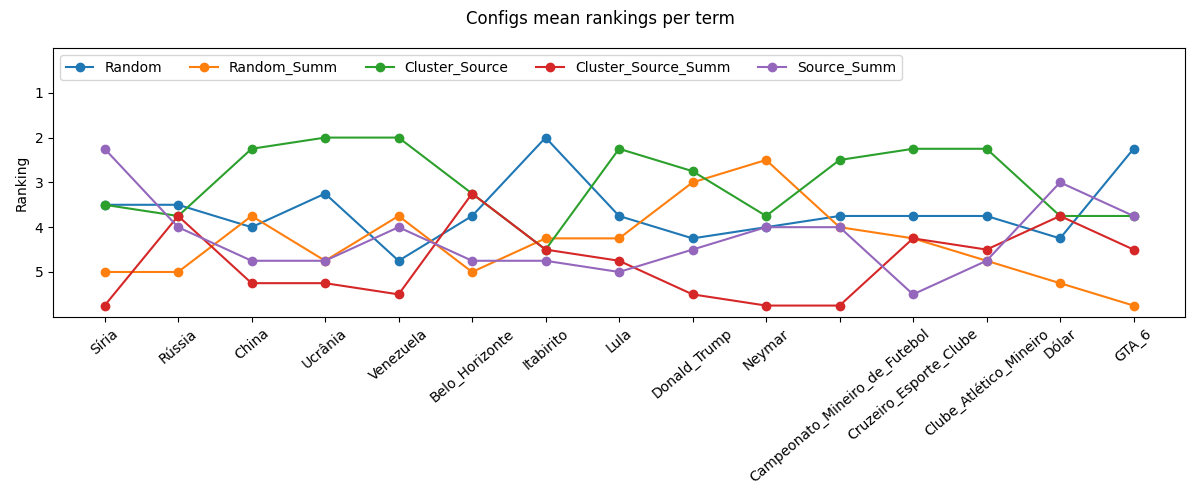

In [17]:
Image(filename='data/assets/rankings/mean_rankings.png')

The configurations names in the legend follow their original order, so:
- Config 1 is 'Random'
- Config 2 is 'Random_Summ'
- Config 3 is 'Cluster_Source'
- Config 4 is 'Cluster_Source_Summ'
- Config 5 is 'Source_Summ'

From the above graph, we can see that Config 3 was the configuration prefered in general. It appears to be the best on the 'locations' and 'football' groups and was predominant in the 'politics' group.

We can also see that, for the terms that had less than 50 headlines (Síria, Itabirito, GTA_6), the configuration 3 lost to configuration 1 (2 times) and 5 (1 time). More specifically, configuration 1 was the best for the 2 terms with the least headlines. That makes sense because, as this configuration samples 20% of the headlines, it becomes a short summary with only correct information, although the information may have somewhat of a duplication of information because of randomness.



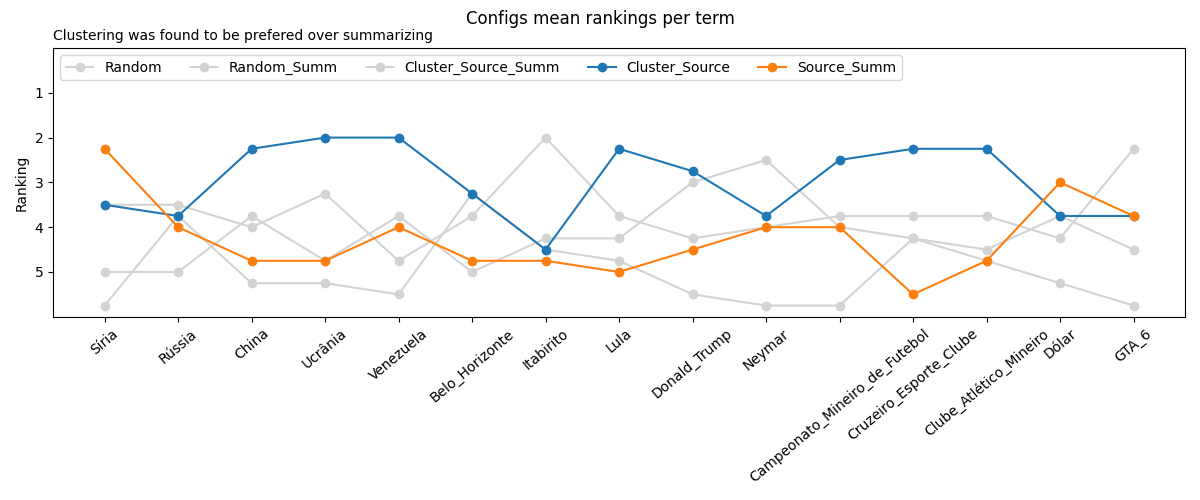

In [18]:
Image(filename='data/assets/rankings/cluster_vs_summ_rankings.png')

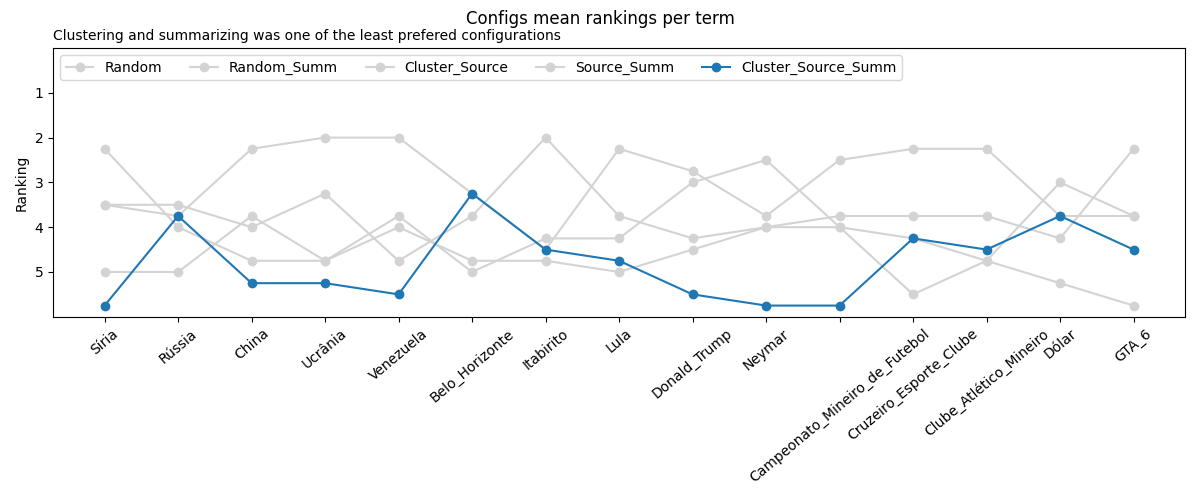

In [19]:
Image(filename='data/assets/rankings/cluster_source_summ.png')

It was expected that the configurations that actually use a LLM to summarize would have a better performance, but that wasn't the case. If we compare the Cluster_Source and Source_Summarize configurations, we see that the former was generally prefered over the latter. Furthermore, the configuration that involves clustering and summarization was one of the least prefered options.

# 5. Usage

Based on the above results, you can use the best configuration found (Cluster_Source) to show only the relevant headlines for a term defining the term and running the cell below. On the first usage, it will download the embedding model. Make sure you are using an environment with GPU access.

In [ ]:
SEARCH_TERM = ""

sampler = main.SamplerTypes.CLUSTER_SAMPLER
joiner = main.JoinerTypes.WITH_SOURCE
solver = main.SolverTypes.AS_IS

embedding_model = 'BAAI/bge-m3'
sampler_kwargs = {'model_name':embedding_model, 'batch_size':32, 'cluster_kwargs':{'eps':0.025}}

joiner_kwargs = {}
solver_kwargs = {}

main.search_and_summarize(SEARCH_TERM, sampler, joiner, solver, sampler_kwargs= sampler_kwargs,
          joiner_kwargs=joiner_kwargs, solver_kwargs=solver_kwargs)